<a href="https://colab.research.google.com/github/KAVYANSHTYAGI/Food-Image-Classifier/blob/main/label_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torch torchvision numpy opencv-python tqdm


In [3]:
pip install ultralytics opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.6/922.6 kB 14.6 MB/s eta 0:00:00



0: 448x640 1 pizza, 35.3ms
Speed: 2.0ms preprocess, 35.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


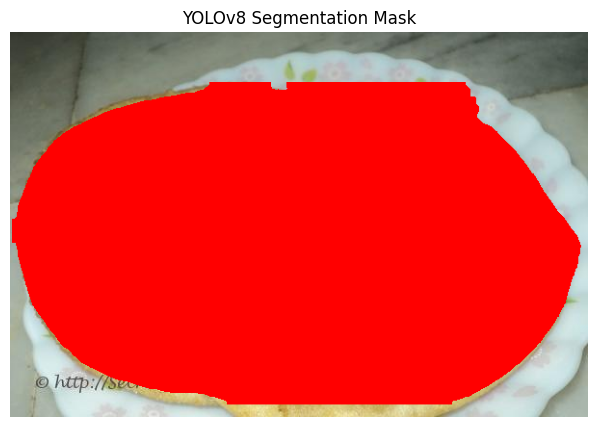

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load YOLOv8-Segmentation Model (Pretrained)
model = YOLO("yolov8m-seg.pt")  # 'm' for medium, you can use 's' for small

def generate_yolo_mask(image_path):
    """
    Runs YOLOv8-Seg on an image and displays the detected object masks.
    """
    # Load Image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run YOLO-Segmentation
    results = model(image)

    # Get Image Shape
    img_h, img_w, _ = image.shape

    # Process Each Detected Object
    for result in results:
        masks = result.masks.data.cpu().numpy()  # Get mask data
        for mask in masks:
            mask = cv2.resize(mask, (img_w, img_h))  # Resize mask to match original image size
            mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary mask

            # Apply mask overlay in red
            image_rgb[mask > 0] = [255, 0, 0]

    # Show Results
    plt.figure(figsize=(10, 5))
    plt.imshow(image_rgb)
    plt.title("YOLOv8 Segmentation Mask")
    plt.axis("off")
    plt.show()

# Process the uploaded image
generate_yolo_mask(uploaded_image_path)


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Load YOLOv8-Seg Model (Pretrained)
model = YOLO("yolov8m-seg.pt")  # 'm' for medium, you can use 's' for small

# Define Directories
MAIN_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final"  # Replace with your dataset directory
OUTPUT_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3"  # Masks will be saved here

def process_image(image_path):
    """
    Process a single image, generate a YOLO segmentation mask, and save it in the corresponding folder.
    """
    try:
        # Compute relative path to maintain folder structure
        relative_path = os.path.relpath(image_path, MAIN_FOLDER)
        mask_relative_path = os.path.join(OUTPUT_FOLDER, relative_path)

        # Create corresponding mask folder in pseudo_masks/
        mask_dir = os.path.dirname(mask_relative_path)
        os.makedirs(mask_dir, exist_ok=True)

        # Load Image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Run YOLO-Segmentation
        results = model(image)

        # ✅ DEBUG: Print YOLO detection results
        print(f"\n🔹 Processing {image_path}")
        print(f"🔹 YOLO Detection Output: {results[0]}")  # Print results to check detections

        # Get Image Shape
        img_h, img_w, _ = image.shape

        # Create an empty mask
        final_mask = np.zeros((img_h, img_w), dtype=np.uint8)

        # Process Each Detected Object
        for result in results:
            if result.masks is not None:
                masks = result.masks.data.cpu().numpy()
                print(f"✅ Detected {len(masks)} objects with masks")  # ✅ DEBUG: Check if masks exist

                for mask in masks:
                    mask = cv2.resize(mask, (img_w, img_h))  # Resize to match original image size
                    mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary mask
                    final_mask = np.maximum(final_mask, mask)  # Combine all object masks

            else:
                print("❌ No masks detected!")

        # ✅ DEBUG: Print mask shape before saving
        print(f"✅ Final Mask Shape: {final_mask.shape}")

        # Save the final mask
        mask_filename = os.path.basename(image_path).split('.')[0] + "_mask.png"
        mask_path = os.path.join(mask_dir, mask_filename)

        # ✅ DEBUG: Print where the mask will be saved
        print(f"✅ Saving Mask: {mask_path}")

        # Save Mask Image
        if cv2.imwrite(mask_path, final_mask):
            print(f"✅ Successfully saved: {mask_path}")
        else:
            print(f"❌ Failed to save: {mask_path}")

        return f"Saved mask: {mask_path}"

    except Exception as e:
        return f"Error processing {image_path}: {str(e)}"

def get_all_image_paths(root_dir):
    """
    Recursively collect all image paths from the given directory.
    """
    image_extensions = {".jpg", ".jpeg", ".png"}
    image_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(subdir, file))

    return image_paths

def process_images_multiprocessing(image_paths):
    """
    Use multiprocessing to process images in parallel.
    """
    num_workers = min(cpu_count(), len(image_paths))  # Use all available CPU cores
    with Pool(processes=num_workers) as pool:
        results = list(tqdm(pool.imap(process_image, image_paths), total=len(image_paths), desc="Generating YOLO Masks"))

    # Print results (optional)
    for res in results:
        print(res)

if __name__ == "__main__":
    print(f"🔍 Scanning images in {MAIN_FOLDER}...")
    image_paths = get_all_image_paths(MAIN_FOLDER)

    # ✅ DEBUG: Print found image paths
    print(f"✅ Found {len(image_paths)} images.")

    if not image_paths:
        print("❌ No images found! Please check the dataset directory.")
    else:
        print(f"🚀 Generating masks using {cpu_count()} CPU cores...\n")
        process_images_multiprocessing(image_paths)

    print("\n✅ All YOLO segmentation masks have been generated and saved in pseudo_masks/")


background removal

In [4]:
import cv2
import numpy as np
import os
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Define Directories
MAIN_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final"  # Original images directory
MASK_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3"  # Corresponding masks directory
OUTPUT_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final"  # Where the segmented images will be saved

# Function to apply the segmentation mask
def remove_background(image_path):
    """
    Loads an image and its corresponding segmentation mask, removes the background, and saves the segmented image.
    """
    try:
        # Compute relative path to maintain folder structure
        relative_path = os.path.relpath(image_path, MAIN_FOLDER)
        mask_path = os.path.join(MASK_FOLDER, relative_path).replace(".jpg", "_mask.png").replace(".jpeg", "_mask.png").replace(".png", "_mask.png")
        output_path = os.path.join(OUTPUT_FOLDER, relative_path).replace(".jpg", "_segmented.png").replace(".jpeg", "_segmented.png").replace(".png", "_segmented.png")

        # Create corresponding mask folder in segmented_images/
        mask_dir = os.path.dirname(output_path)
        os.makedirs(mask_dir, exist_ok=True)

        # Check if mask exists
        if not os.path.exists(mask_path):
            print(f"❌ No mask found for {image_path}, skipping...")
            return

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize mask to match image (if dimensions are different)
        if image.shape[:2] != mask.shape:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        # Convert mask to binary
        mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

        # Convert to 3-channel mask
        mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # Apply mask to remove background
        result = cv2.bitwise_and(image, mask_3ch)

        # Save result
        cv2.imwrite(output_path, result)
        print(f"✅ Saved segmented image: {output_path}")

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

# Function to get all image paths
def get_all_image_paths(root_dir):
    """
    Recursively collect all image paths from the given directory.
    """
    image_extensions = {".jpg", ".jpeg", ".png"}
    image_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(subdir, file))

    return image_paths

# Multiprocessing function
def process_images_multiprocessing(image_paths):
    """
    Use multiprocessing to process images in parallel.
    """
    num_workers = min(cpu_count(), len(image_paths))  # Use all available CPU cores
    with Pool(processes=num_workers) as pool:
        list(tqdm(pool.imap(remove_background, image_paths), total=len(image_paths), desc="Processing Images"))

# Main function
if __name__ == "__main__":
    print(f"🔍 Scanning images in {MAIN_FOLDER}...")
    image_paths = get_all_image_paths(MAIN_FOLDER)

    # Check if images exist
    if not image_paths:
        print("❌ No images found! Please check the dataset directory.")
    else:
        print(f"🚀 Found {len(image_paths)} images. Processing using {cpu_count()} CPU cores...\n")
        process_images_multiprocessing(image_paths)

    print("\n✅ All segmented images have been saved in segmented_images/")


🔍 Scanning images in /content/drive/MyDrive/Food Image Datasets/North Indian/main_final...
🚀 Found 10066 images. Processing using 96 CPU cores...



Processing Images:   0%|          | 0/10066 [00:00<?, ?it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/3.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/81.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/83.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/22.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/7.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/51.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/87.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/23.jpeg, skipp

Processing Images:   0%|          | 1/10066 [00:00<2:31:20,  1.11it/s]





❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/1.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/33.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/34.jpeg, skipping...












































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North 

Processing Images:   3%|▎         | 265/10066 [00:01<00:35, 274.06it/s]







































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/102.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/103.jpeg, skipping...❌ No mask found 

Processing Images:   5%|▌         | 526/10066 [00:02<00:48, 198.44it/s]














































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/99.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/98.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/100.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/102.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/103.jpeg, skippin

Processing Images:   8%|▊         | 838/10066 [00:02<00:24, 372.92it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/222.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/224.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/223.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/226.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/227.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/228.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/294.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/Nor

Processing Images:  10%|▉         | 981/10066 [00:04<00:44, 202.67it/s]















❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/102.jpeg, skipping...





❌ No mask found for /content/drive/

Processing Images:  12%|█▏        | 1202/10066 [00:04<00:29, 298.00it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/219.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/220.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/221.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/222.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/286.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/223.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Foo

Processing Images:  13%|█▎        | 1356/10066 [00:05<00:32, 268.77it/s]





























































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/97.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/98.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/99.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/101.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/102.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Dal Makhni/103.jpeg, skipping...❌ No mask found for /content/drive/MyD

Processing Images:  15%|█▌        | 1551/10066 [00:05<00:29, 290.49it/s]





























































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/egg bhurji - Google Search/102.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/mai

Processing Images:  17%|█▋        | 1667/10066 [00:07<00:42, 199.80it/s]































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/97.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/102.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/g

Processing Images:  20%|██        | 2017/10066 [00:07<00:22, 364.52it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/229.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/230.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/231.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/293.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/232.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/233.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/ghewar - Google Search/234.jpeg, skipping...❌ No mask fou

Processing Images:  22%|██▏       | 2202/10066 [00:07<00:17, 440.88it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/193.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/195.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/197.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/198.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/199.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/200.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/201.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/tra

Processing Images:  24%|██▍       | 2441/10066 [00:07<00:12, 602.52it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/146.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/87.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/89.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/90.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/91.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/92.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/93.jpeg, sk

Processing Images:  27%|██▋       | 2710/10066 [00:07<00:08, 823.60it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/212.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/213.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/214.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/215.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/216.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/217.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/218.jpeg

Processing Images:  29%|██▉       | 2966/10066 [00:07<00:06, 1051.69it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/351.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/352.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/353.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/354.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/356.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/355.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kathi roll - Google Search/357.jpe

Processing Images:  32%|███▏      | 3211/10066 [00:07<00:05, 1270.67it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/41.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/42.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/40.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/44.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/45.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/46.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/47.jpeg, skipping...
❌ No mask found for /content

Processing Images:  34%|███▍      | 3459/10066 [00:08<00:04, 1492.40it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/207.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/209.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/210.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/211.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/212.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/213.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/215.jpeg, skipping...
❌ No mask found for

Processing Images:  37%|███▋      | 3691/10066 [00:08<00:03, 1663.87it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/lassi - Google Search/103.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/lassi - Google Search/105.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/lassi - Google Search/104.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/33.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/36.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/lassi - Google Search/106.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/lassi - Google Search/107.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/F

Processing Images:  39%|███▉      | 3924/10066 [00:08<00:03, 1810.15it/s]



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/104.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/105.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/106.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/107.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/108.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/110.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/109.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_fina

Processing Images:  41%|████▏     | 4162/10066 [00:08<00:03, 1949.93it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/2.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/3.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/4.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/5.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/6.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/7.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/8.j

Processing Images:  44%|████▍     | 4407/10066 [00:08<00:02, 2071.39it/s]



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/148.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/150.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/149.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/10.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/151.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Google Search/152.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/masala papad - Goog

Processing Images:  46%|████▌     | 4643/10066 [00:08<00:02, 2139.55it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/82.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/83.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/85.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/86.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/84.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/87.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/9

Processing Images:  49%|████▊     | 4905/10066 [00:08<00:02, 2271.20it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/208.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/209.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/210.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/213.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/211.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/214.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Sea

Processing Images:  51%|█████     | 5148/10066 [00:08<00:02, 2189.87it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/80.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/81.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/83.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/82.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/84.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/85.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/87.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/mix veg/86.jpeg, skipping...

Processing Images:  53%|█████▎    | 5379/10066 [00:08<00:02, 1995.88it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/70.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/71.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/73.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/72.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/74.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/76.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/77.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/75.jpeg, skipping...❌ No mask found 

Processing Images:  56%|█████▌    | 5654/10066 [00:08<00:02, 2186.14it/s]



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/205.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/207.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/208.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/206.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/1.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/2.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/3.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/4.jpeg, skipping...❌ No mask found f

Processing Images:  58%|█████▊    | 5883/10066 [00:09<00:01, 2151.88it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/164.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/165.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/166.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/167.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/168.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/169.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/170.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/naan/171.jpeg, skipping...❌ No mask found f

Processing Images:  61%|██████    | 6121/10066 [00:09<00:01, 2214.19it/s]



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/39.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/41.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/40.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/43.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/44.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/42.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/45.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/t

Processing Images:  63%|██████▎   | 6357/10066 [00:09<00:01, 2253.58it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/201.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/150.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/151.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/153.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/152.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/154.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/155.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_fi

Processing Images:  66%|██████▌   | 6611/10066 [00:09<00:01, 2332.95it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/302.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/303.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/304.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/305.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/306.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/307.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/309.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_fin

Processing Images:  68%|██████▊   | 6848/10066 [00:09<00:01, 2315.44it/s]




❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/123.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/125.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/126.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/127.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/128.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/130.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/131.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_fin

Processing Images:  70%|███████   | 7082/10066 [00:09<00:01, 2296.69it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/278.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/280.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/281.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/282.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/283.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/284.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/paneer tikka/285.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final

Processing Images:  73%|███████▎  | 7336/10066 [00:09<00:01, 2366.56it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/64.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/65.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/66.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/68.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/67.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/69.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bha

Processing Images:  75%|███████▌  | 7574/10066 [00:09<00:01, 2325.37it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/66.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/67.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/68.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/69.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/70.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/71.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/tr

Processing Images:  78%|███████▊  | 7808/10066 [00:09<00:00, 2306.52it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/38.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/90.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/41.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/42.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/43.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/44.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Rajma Chawal/45.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/tra

Processing Images:  80%|███████▉  | 8040/10066 [00:10<00:01, 1137.99it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/118.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/184.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/117.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/119.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/120.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/121.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/t

Processing Images:  82%|████████▏ | 8218/10066 [00:10<00:01, 976.09it/s] 































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/90.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/92.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/91.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/88.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/93.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/95.jpeg, skipping...❌ 

Processing Images:  83%|████████▎ | 8363/10066 [00:10<00:02, 839.42it/s]



































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/102.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/chole kulcha food images - Google Search/101.jpeg, skippi

Processing Images:  84%|████████▍ | 8481/10066 [00:11<00:02, 670.13it/s]
































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/51.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/59.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/57.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/58.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/63.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/60.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/61.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food 

Processing Images:  85%|████████▌ | 8575/10066 [00:11<00:02, 628.70it/s]









































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/94.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/84.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/93.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/87.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/89.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/86.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - 

Processing Images:  86%|████████▌ | 8656/10066 [00:11<00:02, 592.00it/s]






































































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/97.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/100.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/99.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/101.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/kathi roll - Google Search/102.jpeg, skipping...





❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North I

Processing Images:  87%|████████▋ | 8727/10066 [00:11<00:02, 451.54it/s]














































❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/23.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/21.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/25.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/30.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/27.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/masala papad - Google Search/28.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/test

Processing Images:  88%|████████▊ | 8823/10066 [00:12<00:03, 413.65it/s]





























❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/1.jpeg, skipping...







❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/2.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/3.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/4.jpeg, skipping...



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/5.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/6.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/7.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/8.jpeg, skipping...❌

Processing Images:  93%|█████████▎| 9380/10066 [00:12<00:00, 1146.33it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/77.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/76.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/78.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/79.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/80.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/81.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/palak panner/82.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/pa

Processing Images:  95%|█████████▌| 9582/10066 [00:12<00:00, 1286.06it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/pav bhaji images - Google Search/36.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/pav bhaji images - Google Search/34.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/pav bhaji images - Google Search/35.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/prawn curry indian - Google Search/1.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/prawn curry indian - Google Search/2.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/prawn curry indian - Google Search/3.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/prawn cu

Processing Images:  97%|█████████▋| 9787/10066 [00:12<00:00, 1432.92it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/21.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/red sauce pasta - Google Search/42.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/red sauce pasta - Google Search/43.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/24.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/red sauce pasta - Google Search/44.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/red sauce pasta - Google Search/45.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/red sauce pasta - Google Sear

Processing Images:  99%|█████████▉| 9988/10066 [00:12<00:00, 1536.77it/s]

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/95.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/veg sandwich - Google Search/15.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/96.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/97.jpeg, skipping...


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/98.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/99.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/spaghetti - Google Search/100.jpeg, skipping...❌ 

Processing Images: 100%|██████████| 10066/10066 [00:12<00:00, 799.02it/s]


❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/13.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/14.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/15.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/16.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/17.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/sweet masala corn - Google Search/18.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/swe



❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/35.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/36.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/38.jpeg, skipping...

❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/39.jpeg, skipping...
❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/37.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white sauce pasta - Google Search/40.jpeg, skipping...❌ No mask found for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/white

In [6]:
import cv2
import numpy as np
import os
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# Define Directories
MAIN_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/main_final"  # Original images directory
MASK_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3"  # Corresponding masks directory
OUTPUT_FOLDER = "/content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2"  # Output path for segmented images

def find_mask(image_filename, mask_folder):
    """
    Tries to find the corresponding mask file based on the image filename.
    """
    base_name = os.path.splitext(image_filename)[0]  # Remove extension
    possible_extensions = [".png", ".jpg", ".jpeg"]

    # Try finding masks with different extensions
    for ext in possible_extensions:
        mask_path = os.path.join(mask_folder, base_name + "_mask" + ext)
        if os.path.exists(mask_path):
            return mask_path  # Found matching mask

    return None  # No matching mask found

def remove_background(image_path):
    """
    Loads an image and its corresponding mask, removes the background, and saves the segmented image.
    """
    try:
        # Compute relative path to maintain folder structure
        relative_path = os.path.relpath(image_path, MAIN_FOLDER)
        mask_folder = os.path.join(MASK_FOLDER, os.path.dirname(relative_path))
        output_path = os.path.join(OUTPUT_FOLDER, relative_path).replace(".jpg", "_segmented.png").replace(".jpeg", "_segmented.png").replace(".png", "_segmented.png")

        # Create output folder if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Find the corresponding mask file
        mask_path = find_mask(os.path.basename(image_path), mask_folder)

        if mask_path is None:
            print(f"❌ No mask found for {image_path}, skipping...")
            return

        # ✅ DEBUG: Print found image and mask
        print(f"🔹 Processing Image: {image_path}")
        print(f"🔹 Found Mask: {mask_path}")

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ✅ DEBUG: Check if image and mask loaded properly
        if image is None:
            print(f"❌ Error loading image: {image_path}")
            return
        if mask is None:
            print(f"❌ Error loading mask: {mask_path}")
            return

        # Resize mask to match image (if different sizes)
        if image.shape[:2] != mask.shape:
            print(f"⚠ Resizing mask from {mask.shape} to {image.shape[:2]}")
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        # Convert mask to binary
        mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

        # Convert mask to 3 channels
        mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # Apply mask to remove background
        result = cv2.bitwise_and(image, mask_3ch)

        # ✅ DEBUG: Check if output image has data
        if result is None or result.sum() == 0:
            print(f"❌ Error: Empty segmentation result for {image_path}")
            return

        # Save the segmented image
        cv2.imwrite(output_path, result)
        print(f"✅ Saved segmented image: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")


def get_all_image_paths(root_dir):
    """
    Recursively collects all image paths from the given directory.
    """
    image_extensions = {".jpg", ".jpeg", ".png"}
    image_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(subdir, file))

    return image_paths

def process_images_multiprocessing(image_paths):
    """
    Uses multiprocessing to process images in parallel.
    """
    num_workers = min(cpu_count(), len(image_paths))  # Use available CPU cores
    with Pool(processes=num_workers) as pool:
        list(tqdm(pool.imap(remove_background, image_paths), total=len(image_paths), desc="Processing Images"))

if __name__ == "__main__":
    print(f"🔍 Scanning images in {MAIN_FOLDER}...")
    image_paths = get_all_image_paths(MAIN_FOLDER)

    # Check if images exist
    if not image_paths:
        print("❌ No images found! Please check the dataset directory.")
    else:
        print(f"🚀 Found {len(image_paths)} images. Processing using {cpu_count()} CPU cores...\n")
        process_images_multiprocessing(image_paths)

    print("\n✅ All segmented images have been saved in segmented_images/")


🔍 Scanning images in /content/drive/MyDrive/Food Image Datasets/North Indian/main_final...
🚀 Found 10066 images. Processing using 96 CPU cores...



Processing Images:   0%|          | 0/10066 [00:00<?, ?it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/1.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/83.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/38.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/1_mask.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/84.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/86.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/2.jpeg

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/89.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3

Processing Images:   0%|          | 1/10066 [00:01<3:16:21,  1.17s/it]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Aloo Puri/70_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/109.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/109_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/110.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/110_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Aloo Puri/88_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Aloo Puri/47_segmented_segmented.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2

Processing Images:   0%|          | 3/10066 [00:01<1:22:41,  2.03it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/144.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/144_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Aloo Puri/32_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/145.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/145_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Aloo Puri/77_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Aloo Puri/146.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Aloo Puri/146_mask.png
✅ Sa

Processing Images:   0%|          | 4/10066 [00:06<5:36:47,  2.01s/it]

❌ Error: Empty segmentation result for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/187.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/194.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Bhindi Masala/194_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/195.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Bhindi Masala/195_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Bhindi Masala/149_segmented_segmented.png
❌ Error: Empty segmentation result for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Bhindi Masala/188.jpeg
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmen

Processing Images:   0%|          | 42/10066 [00:09<30:30,  5.48it/s] 

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/112.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Chhole Bhature/112_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Chhole Bhature/61_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Chhole Bhature/68_segmented_segmented.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Chhole Bhature/113.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Chhole Bhature/113_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Bhindi Masala/111_segmented_segmented.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets

Processing Images:   1%|          | 64/10066 [00:19<50:54,  3.27it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/391.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/chole kulcha food images - Google Search/391_mask.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/chole kulcha food images - Google Search/312_segmented_segmented.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/chole kulcha food images - Google Search/392.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/chole kulcha food images - Google Search/392_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/chole kulcha food images - Google Search/308_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food

Processing Images:   4%|▍         | 405/10066 [00:34<10:41, 15.06it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/13.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Gulab Jamun/13_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/Gulab Jamun/2_segmented_segmented.png
❌ Error: Empty segmentation result for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/6.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/14.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Gulab Jamun/14_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/15.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Gulab Jamun/15_mask.png✅ Saved 

Processing Images:  10%|█         | 1031/10066 [00:36<03:16, 46.04it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/ghewar - Google Search/231_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/110.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Gulab Jamun/110_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/111.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/Gulab Jamun/111_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/ghewar - Google Search/341_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/Gulab Jamun/112.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main

Processing Images:  10%|█         | 1031/10066 [00:53<03:16, 46.04it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/kathi roll - Google Search/378_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/kathi roll - Google Search/376_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/kathi roll - Google Search/342_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/kathi roll - Google Search/375_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/kulfi - Google Search/1.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/kulfi - Google Search/1_mask.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/k

Processing Images:  14%|█▎        | 1382/10066 [01:04<06:12, 23.34it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/59.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/60.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/malai kofta/59_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/malai kofta/60_mask.png

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/malai kofta/21_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/malai kofta/61.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/malai kofta/61_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/kulfi - Google Search/191_segment

Processing Images:  22%|██▏       | 2176/10066 [01:17<03:44, 35.14it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/251.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/252.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/matar paneer - Google Search/253.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/matar paneer - Google Search/251_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/matar paneer - Google Search/252_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/matar paneer - Google Search/253_mask.png


✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/matar paneer - Google Search/170_segmented_segmented.png
🔹 Processing I

Processing Images:  22%|██▏       | 2205/10066 [01:25<04:41, 27.92it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/momos/52_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/113.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/114.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/113_mask.png

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/114_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/momos/50_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/115.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/115_mask.png
✅ Saved segmented image: /content/dr

Processing Images:  31%|███       | 3080/10066 [01:26<01:56, 59.91it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/momos/67_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/141.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/142.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/143.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/momos/144.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/141_mask.png



🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/142_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/momos/143_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indi

Processing Images:  36%|███▌      | 3577/10066 [01:37<02:00, 53.93it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/285.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/palak panner/285_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/palak panner/186_segmented_segmented.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/palak panner/187_segmented_segmented.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/286.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/palak panner/287.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/palak panner/286_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/palak

Processing Images:  43%|████▎     | 4347/10066 [01:45<01:26, 66.17it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/27.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/pav bhaji images - Google Search/27_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/paneer tikka/262_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/pav bhaji images - Google Search/7_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/28.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/29.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/pav bhaji images - Google Search/28

Processing Images:  52%|█████▏    | 5199/10066 [01:45<00:46, 104.76it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/67.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/pav bhaji images - Google Search/67_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/paneer tikka/282_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/pav bhaji images - Google Search/68.jpeg
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/pav bhaji images - Google Search/33_segmented_segmented.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/pav bhaji images - Google Search/68_mask.png

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/paneer tikka/286_s

Processing Images:  52%|█████▏    | 5278/10066 [01:47<00:48, 98.96it/s] 


✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/pav bhaji images - Google Search/2_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/27.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/28.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/prawn curry indian - Google Search/27_mask.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/prawn curry indian - Google Search/28_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/prawn curry indian - Google Search/29.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/prawn curry indian - Google 

Processing Images:  53%|█████▎    | 5334/10066 [02:03<01:48, 43.53it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/red sauce pasta - Google Search/13_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/red sauce pasta - Google Search/81_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/red sauce pasta - Google Search/129.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/red sauce pasta - Google Search/130.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/red sauce pasta - Google Search/131.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/red sauce pasta - Google Search/132.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/red sauce pasta - Google

Processing Images:  54%|█████▍    | 5430/10066 [02:16<02:44, 28.24it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/spaghetti - Google Search/326_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/spaghetti - Google Search/401.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/spaghetti - Google Search/401_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/spaghetti - Google Search/402.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/spaghetti - Google Search/402_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/spaghetti - Google Search/327_segmented_segmented.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/spaghetti - Google Search/332_segmen

Processing Images:  56%|█████▌    | 5629/10066 [02:22<02:31, 29.33it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/35.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/35_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/sweet masala corn - Google Search/84_segmented_segmented.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/sweet masala corn - Google Search/81_segmented_segmented.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/36.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/37.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search

Processing Images:  58%|█████▊    | 5793/10066 [02:25<02:09, 33.12it/s]

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/176_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/veg sandwich - Google Search/107_segmented_segmented.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/177.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/177_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/178.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/178_mask.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/179.jpeg

🔹 Found Mask: 

Processing Images:  59%|█████▊    | 5896/10066 [02:31<02:27, 28.36it/s]


🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/383.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/veg sandwich - Google Search/384.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/383_mask.png

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/veg sandwich - Google Search/384_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/veg sandwich - Google Search/302_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/veg sandwich - Google Search/276_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/veg sandwich - G

Processing Images:  59%|█████▊    | 5896/10066 [02:43<02:27, 28.36it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/263.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/264.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/white sauce pasta - Google Search/263_mask.png
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/white sauce pasta - Google Search/264_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/125_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/181_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/trainin

Processing Images:  65%|██████▍   | 6498/10066 [02:48<01:51, 32.12it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/502.jpeg✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/414_segmented_segmented.png

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/white sauce pasta - Google Search/502_mask.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/training/white sauce pasta - Google Search/503.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/training/white sauce pasta - Google Search/503_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/415_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/trainin

Processing Images:  65%|██████▍   | 6522/10066 [02:52<02:06, 28.06it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/Bhindi Masala/11_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/517_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Bhindi Masala/61.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Bhindi Masala/62.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Bhindi Masala/63.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Bhindi Masala/61_mask.png

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Bhindi Masala/62_mask.png
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3

Processing Images:  78%|███████▊  | 7833/10066 [02:53<00:23, 95.57it/s]


🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Chhole Bhature/22.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Chhole Bhature/22_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/Chhole Bhature/5_segmented_segmented.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/training/white sauce pasta - Google Search/530_segmented_segmented.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Chhole Bhature/23.jpeg
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Chhole Bhature/24.jpeg🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Chhole Bhature/23_mask.png

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_mask

Processing Images:  79%|███████▉  | 7941/10066 [03:02<00:33, 62.82it/s]

❌ Error: Empty segmentation result for /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/15.jpeg🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/20.jpeg

🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Gulab Jamun/20_mask.png✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/Bhindi Masala/44_segmented_segmented.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/21.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Gulab Jamun/21_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/ghewar - Google Search/50_segmented_segmented.png🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testi

Processing Images:  81%|████████  | 8125/10066 [03:02<00:26, 74.13it/s]

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/28.jpeg
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/ghewar - Google Search/54_segmented_segmented.png🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Gulab Jamun/28_mask.png

🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/Gulab Jamun/29.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/Gulab Jamun/29_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/Gulab Jamun/5_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/ghewar - Google Search/53_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Ind

Processing Images:  81%|████████  | 8125/10066 [03:13<00:26, 74.13it/s]

✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/mix veg/49_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/momos/53.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/momos/53_mask.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/mix veg/51_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/mix veg/27_segmented_segmented.png
✅ Saved segmented image: /content/drive/MyDrive/Food Image Datasets/North Indian/segmented_final2/testing/mix veg/56_segmented_segmented.png
🔹 Processing Image: /content/drive/MyDrive/Food Image Datasets/North Indian/main_final/testing/naan/1.jpeg
🔹 Found Mask: /content/drive/MyDrive/Food Image Datasets/North Indian/pseudo_masks_main3/testing/naan/1_m

Processing Images: 100%|██████████| 10066/10066 [03:38<00:00, 46.17it/s]


✅ All segmented images have been saved in segmented_images/


In [ ]:
def remove_background(image_path):
    """
    Loads an image and its corresponding mask, removes the background, and saves the segmented image.
    """
    try:
        # Compute relative path to maintain folder structure
        relative_path = os.path.relpath(image_path, MAIN_FOLDER)
        mask_folder = os.path.join(MASK_FOLDER, os.path.dirname(relative_path))
        output_path = os.path.join(OUTPUT_FOLDER, relative_path).replace(".jpg", "_segmented.png").replace(".jpeg", "_segmented.png").replace(".png", "_segmented.png")

        # Create output folder if it doesn't exist
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        # Find the corresponding mask file
        mask_path = find_mask(os.path.basename(image_path), mask_folder)

        if mask_path is None:
            print(f"❌ No mask found for {image_path}, skipping...")
            return

        # ✅ DEBUG: Print found image and mask
        print(f"🔹 Processing Image: {image_path}")
        print(f"🔹 Found Mask: {mask_path}")

        # Load image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ✅ DEBUG: Check if image and mask loaded properly
        if image is None:
            print(f"❌ Error loading image: {image_path}")
            return
        if mask is None:
            print(f"❌ Error loading mask: {mask_path}")
            return

        # Resize mask to match image (if different sizes)
        if image.shape[:2] != mask.shape:
            print(f"⚠ Resizing mask from {mask.shape} to {image.shape[:2]}")
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        # Convert mask to binary
        mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]

        # Convert mask to 3 channels
        mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

        # Apply mask to remove background
        result = cv2.bitwise_and(image, mask_3ch)

        # ✅ DEBUG: Check if output image has data
        if result is None or result.sum() == 0:
            print(f"❌ Error: Empty segmentation result for {image_path}")
            return

        # Save the segmented image
        cv2.imwrite(output_path, result)
        print(f"✅ Saved segmented image: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")
